In [2]:
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib import cm

In [3]:
import numpy as np
from scipy.stats import norm, multivariate_normal

In [4]:
from doframework.core.gp import gp_model
from doframework.core.poi import probability_of_improvement, POI
from doframework.core.utils import sample_standard_simplex

# Probability of Improvement (PoI) and Constraint Satisfaction (PoCS)

___

$\newcommand{\R}{\mathbb{R}}
\newcommand{\bg}{\mathbf{g}}
\newcommand{\bh}{\mathbf{h}}
\newcommand{\bhh}{{\widehat \bh}}
\newcommand{\bx}{\mathbf{x}}
\newcommand{\bxh}{{\widehat \bx}}
\newcommand{\bw}{\mathbf{w}}
\newcommand{\by}{\mathbf{y}}
\newcommand{\bz}{\mathbf{z}}
\newcommand{\bzero}{\mathbf{0}}$

A mathematical decision-optimization (DO) model with decision variables $\bx \in \R^n$ and uncontrollable variables $\bw \in \R^m$ may include parts $f$ (objective) and $h$ (constraint) that need to be learned from data.

$$\begin{equation*}
            \begin{array}{rll}
                {\bx^*(\bw)} \in \arg \min_{\bx \in \R^n, \by \in \R^m} & {f(\bx,\by,\bw)} &  \\
                \mbox{s.t.} & \bg(\bx,\by,\bw) \leq \bzero \\
                & \by = {\bh} (\bx,\bw) & \\
                & \bx \in \Omega(\bw) & \mbox{(polytope)}
            \end{array}
\end{equation*}$$

This notebook demonstrates the use of the Probability of Improvement (**PoI**) and the Probability of Constraint satisfaction (**PoCS**) as a way to assess the quality of a solution $\bxh = \bxh(\bw)$ associated with an uncotrollable parameter $\bw$ coming from a *learned* mathematical decision-optimization model where either $f$ or $h$ are learned.

# Test Function

We will demonstrate PoI and PoCS using the test function below. It will serve us both as the true constraint $h$ in some mathematical DO model and later on as the true objective $f$.

In [5]:
f = lambda x, w: (x**2 + w**2)*np.sin(np.pi*x*w/16)
fvect = np.vectorize(f)

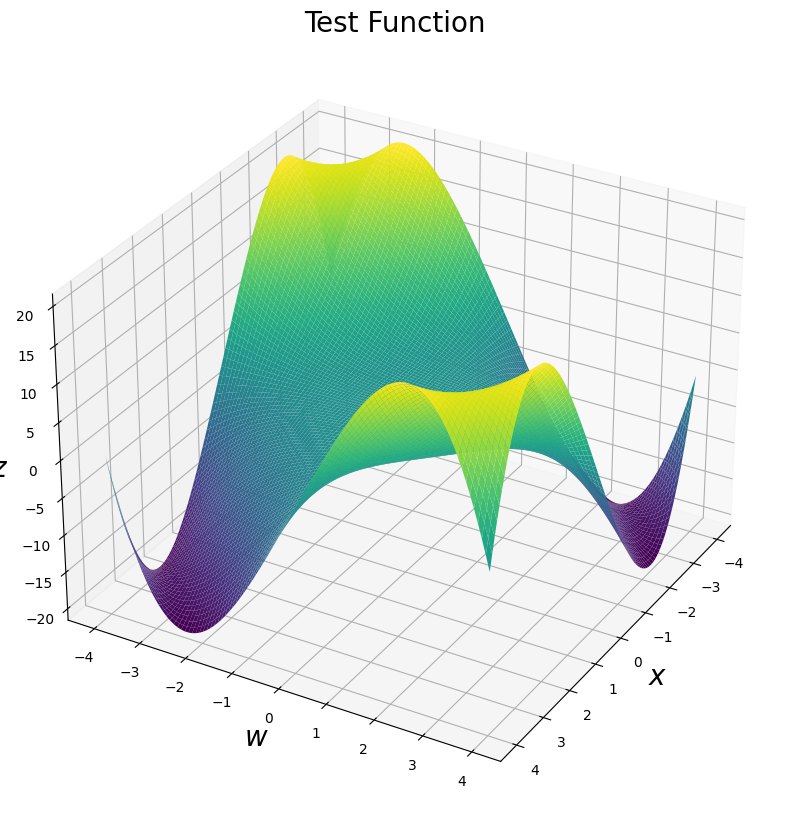

In [6]:
fig = plt.figure(figsize=(10,10))
ln = np.linspace(-4,4,100)[:,None]
x, y = np.meshgrid(ln, ln)

ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, fvect(x,y), rstride=1, cstride=1, cmap=cm.viridis)
ax.view_init(elev=30, azim=30)
ax.set_xlabel(r'$x$',fontsize=20)
ax.set_ylabel(r'$w$',fontsize=20)
ax.set_zlabel(r'$z$',fontsize=20)
ax.set_title(r'Test Function',fontsize=20);

# Data

We will generate synthetic noised data for the test function. This data poses as historical data in its incarnation either as objective $f$ data or as constraint $h$ data.

We will generate data from a multivariate, non-spherical normal distribution (just to keep things a bit interesting).

In [7]:
d = 2 # dimension
N = 500 # number of points in dataset
noise = 0.5 # noising function values

In [8]:
mu = np.zeros(d)
sigma = np.diag(2*d*sample_standard_simplex(d))
X = multivariate_normal(mean=mu,cov=sigma).rvs(size=N)

In [9]:
y = fvect(X[:,0],X[:,1]) + norm(loc=0,scale=noise).rvs(size=X.shape[0])
y = y[:,None]

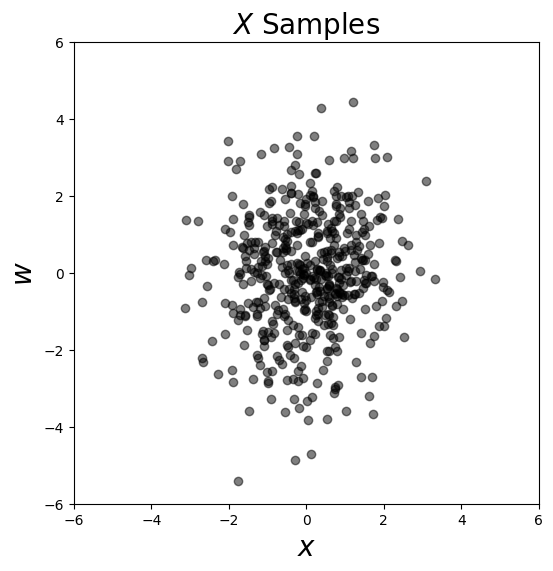

In [10]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
ax.scatter(X[:,0],X[:,1],color='black',alpha=0.5)
ax.set_xlabel(r'$x$',fontsize=20)
ax.set_ylabel(r'$w$',fontsize=20)
ax.set_xlim(-6,6)
ax.set_ylim(-6,6)
ax.set_title(r'$X$ Samples',fontsize=20);

# GP 

To estimate PoI and PoCS we use a __[Gaussian Process (GP)](http://gaussianprocess.org/gpml/)__ model. 

The basic GP model below relies on Maximum Likelihood Estimatiom (MLE) to optimize the hyper-parameters of the Gaussian process ARD (Automatic Relevance Determination) kernel. 

Our `gp_model` is a wrapper for __[GPy](https://gpy.readthedocs.io/en/deploy/#)__.

In [11]:
model = gp_model(X,y)

Let's test the model's prediction $\mu$ at the origin and its variance $\sigma^2$. This is where we expect low variance.

In [12]:
origin = np.array([[0.,0.]])
mu_origin, sigma_origin_sq = model.predict(origin)
mu_origin, sigma_origin_sq = mu_origin[0][0], sigma_origin_sq[0][0]
print('f value at the origin: {:.3f}'.format(f(origin[0,0],origin[0,1])))
print('mean at the origin: {:.3f}'.format(mu_origin))
print('variance at the origin: {:.3f}'.format(sigma_origin_sq))

f value at the origin: 0.000
mean at the origin: -0.065
variance at the origin: 0.270


We can use other methods of GP kernel hyper-parameter optimization, such as __[Hamiltonian Monte Carlo](https://en.wikipedia.org/wiki/Hamiltonian_Monte_Carlo)__ (HMC). 

We use the following parameters to enable HMC:

* ```is_mcmc```: True to use HMC to optimize kernel hyper-parameters.
* ```num_samples```: number of samples in an MC chain.
* ```hmc_iters```: number of MC chains to sample.
* ```plot_kernel_posteriors```: True to plot kernel hyper-parameter posteriors when using HMC.

In [13]:
model_hmc = gp_model(X,y,is_mcmc=True,num_samples=1000,hmc_iters=5,plot_kernel_posteriors=False)

# PoCS

The Probability of Constraint Satisfaciton (PoCS) at a point $(\bx,\bw)$ is defined as

$$\Pr[\bh(\bx,\bw) \leq t],$$

Namely, the probability that the value of the constraint $\bh$ at $(\bx,\bw)$ is $\leq$ than some threshold $t$. 

Assuming that the vector-valued function $\bg$ incorporates the constraint 

$$\by - t \leq \bzero,$$

PoCS assesses the feasiblity of a *learned* solution $\bxh = \bxh(\bw)$.

# Test I

In this example, the test function acts as the constraint $h$ of which we have historical data. 

We will estimate $\Pr[h(\bx,\bw) \leq t]$. 

Let's choose some dummy solutions, uncontrollable values, and thresholds to test the PoCS.

Below we initialize:

**points**: dummy "solutions" $\hat{x}$ (1st coordinate) associated with uncontrollables $w$ (2nd coordinate).<br>
**ts**: dummy thresholds $t$.

In [14]:
points = np.array([[1.,1.],[1.,-1.],[3.,3.],[4.,4.]])
ts = np.array([[4.,4.,4.,4.]])

Here is how we calculate the PoCS using the function ```probability_of_improvement```.

In [15]:
probability_of_improvement(points,ts,model,is_constraint=True,upper_bound=True)

[POI(point=[1. 1.], probability=1.0, upper_bound=True, threshold=[4.]),
 POI(point=[1. 1.], probability=1.0, upper_bound=True, threshold=[4.]),
 POI(point=[1. 1.], probability=1.0, upper_bound=True, threshold=[4.]),
 POI(point=[1. 1.], probability=1.0, upper_bound=True, threshold=[4.]),
 POI(point=[ 1. -1.], probability=1.0, upper_bound=True, threshold=[4.]),
 POI(point=[ 1. -1.], probability=1.0, upper_bound=True, threshold=[4.]),
 POI(point=[ 1. -1.], probability=1.0, upper_bound=True, threshold=[4.]),
 POI(point=[ 1. -1.], probability=1.0, upper_bound=True, threshold=[4.]),
 POI(point=[3. 3.], probability=0.0, upper_bound=True, threshold=[4.]),
 POI(point=[3. 3.], probability=0.0, upper_bound=True, threshold=[4.]),
 POI(point=[3. 3.], probability=0.0, upper_bound=True, threshold=[4.]),
 POI(point=[3. 3.], probability=0.0, upper_bound=True, threshold=[4.]),
 POI(point=[4. 4.], probability=0.0, upper_bound=True, threshold=[4.]),
 POI(point=[4. 4.], probability=0.0, upper_bound=True, t

Let's check whether the HMC model gives us similar results. 

<font color='green'>Did the PoCS agree with our expectations for either model?</font> 

In [16]:
probability_of_improvement(points,ts,model_hmc,is_constraint=True,upper_bound=True)

[POI(point=[1. 1.], probability=1.0, upper_bound=True, threshold=[4.]),
 POI(point=[1. 1.], probability=1.0, upper_bound=True, threshold=[4.]),
 POI(point=[1. 1.], probability=1.0, upper_bound=True, threshold=[4.]),
 POI(point=[1. 1.], probability=1.0, upper_bound=True, threshold=[4.]),
 POI(point=[ 1. -1.], probability=1.0, upper_bound=True, threshold=[4.]),
 POI(point=[ 1. -1.], probability=1.0, upper_bound=True, threshold=[4.]),
 POI(point=[ 1. -1.], probability=1.0, upper_bound=True, threshold=[4.]),
 POI(point=[ 1. -1.], probability=1.0, upper_bound=True, threshold=[4.]),
 POI(point=[3. 3.], probability=0.0, upper_bound=True, threshold=[4.]),
 POI(point=[3. 3.], probability=0.0, upper_bound=True, threshold=[4.]),
 POI(point=[3. 3.], probability=0.0, upper_bound=True, threshold=[4.]),
 POI(point=[3. 3.], probability=0.0, upper_bound=True, threshold=[4.]),
 POI(point=[4. 4.], probability=1.0, upper_bound=True, threshold=[4.]),
 POI(point=[4. 4.], probability=1.0, upper_bound=True, t

The further away we get from the data, the less likely it is we'll get high probability values. As we get away from the data, we should consider lower probability values to reflect not only lower predictions but, crucially, lower knowledge or lower certainty.

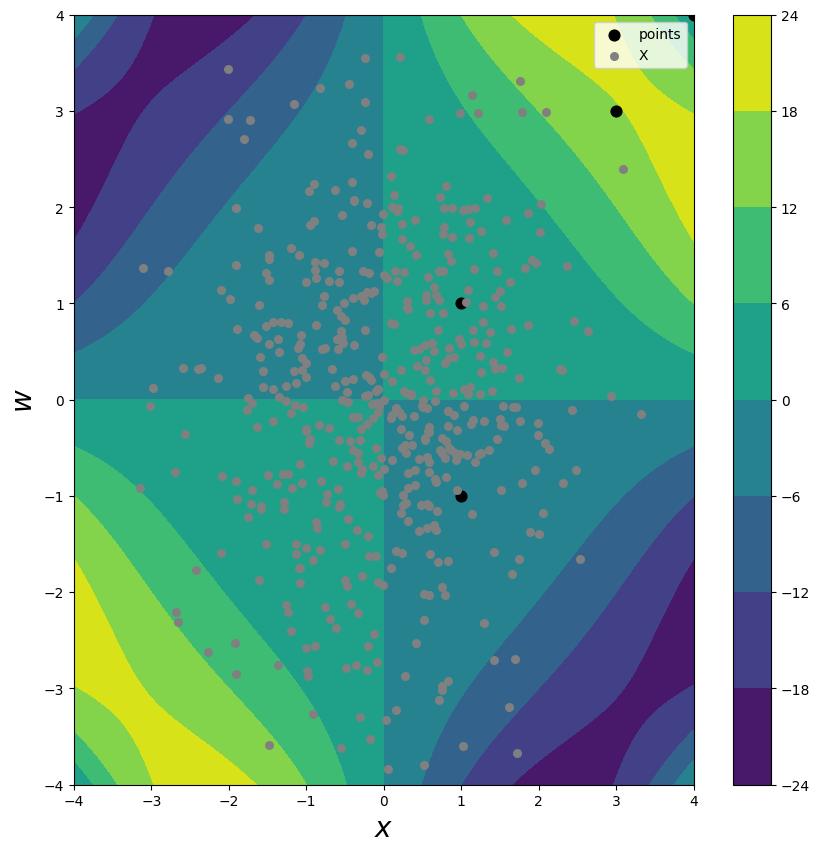

In [17]:
fig = plt.figure(figsize=(10,10))
ln = np.linspace(-4,4,1000)[:,None]
x, y = np.meshgrid(ln, ln)

plt.contourf(x, y, fvect(x,y), cmap=cm.viridis)
plt.colorbar()
plt.scatter(points[:,0],points[:,1],c='black',s=60,label='points')
plt.scatter(X[:,0],X[:,1],c='grey',s=30,label='X')
plt.xlim(-4,4)
plt.ylim(-4,4)
plt.xlabel(r'$x$',fontsize=20)
plt.ylabel(r'$w$',fontsize=20)
plt.legend()
plt.show()

# PoI 

The **Probability of Improvement** (PoI) at a point $(\bx',\bw)$ is defined relative to another point $(\bx'',\bw)$ to be

$$\Pr[f(\bx',\bw) \leq f(\bx',\bw)].$$

As the name suggests, it is the probability that the value of the objective $f$ at $\bx'$ improves upon some other $\bx''$ for the uncontrolable $\bw$. 

PoI assesses the probability that a *learned* solution $\bxh = \bxh(\bw)$ for an uncontrolable $\bw$ is better than some known decision $\bx_0 = \bx_0(\bw)$.

# Test II

In this example, the test function acts as the true objective $f$ of which we have historical data. 

We'll choose some dummy solutions ${\widehat x}$ to test against dummy prior decisions $x_0$ associated with uncontrollables $w$.

**points**: dummy "solutions" ${\widehat x}$ (1st coordinate) associated with uncontrollables $w$ (2nd coordinate).<br>
**references**: dummy decisions $x_0$ (1st coordinate) for the same uncontrollables $w$ (2nd coordinate).

In [18]:
points = np.array([[1.,2.],[3.,2.]])
references = np.array([[2.,2.]])

<font color='green'>Does the probability of improvement agrees with our expectations?</font> 

In [19]:
probability_of_improvement(points,references,model,plot_joint_gaussians=False)

[POI(point=[1. 2.], probability=1.0, upper_bound=True, reference=[2. 2.]),
 POI(point=[3. 2.], probability=0.0, upper_bound=True, reference=[2. 2.])]